# diffusion model

![fig](../assets/DDPM.png)

In [ ]:
"""
mean = sqrt(a_hat)*x_0
variance = sqrt(1-a_hat) * random_noise
"""

In [111]:
import torch
from torchvision import transforms

In [195]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [192]:
# define starting input
x0 = torch.randn(2,3,32,32)
x0.shape

torch.Size([2, 3, 32, 32])

In [92]:
# define variance scheduler betas
betas = torch.tensor([0.05,0.1,0.15,0.2,0.25])
betas

tensor([0.0500, 0.1000, 0.1500, 0.2000, 0.2500])

In [93]:
# define timestep
t = torch.tensor([1,3])
t

tensor([1, 3])

In [94]:
# betas -> the amount of noise that are being applied at every timstep of diffusion process
# alphas -> 1-betas --> amount of original image's information that are being preserved affer a diffusion process step
alphas = 1 - betas
alphas

tensor([0.9500, 0.9000, 0.8500, 0.8000, 0.7500])

In [95]:
alpha_hat = torch.cumprod(alphas,axis=0)
alpha_hat

tensor([0.9500, 0.8550, 0.7268, 0.5814, 0.4360])

In [101]:
# get correctsponing alpha_hat by timestep, this case first value, third value
alpha_hat_t = alpha_hat.gather(-1,t)

# reshape the result for multiply with input
alpha_hat_t = alpha_hat_t.reshape(-1,1,1,1)

In [97]:
# noise is tensor is the same shape of x_0, the value is gaussian distribution
noise = torch.rand_like(x0)
noise.shape

torch.Size([2, 3, 32, 32])

In [103]:
mean = alpha_hat_t.sqrt() * x0
variance = torch.sqrt(1-alpha_hat_t) *noise
print('mean',mean.shape)
print('variance',variance.shape)

mean torch.Size([2, 3, 32, 32])
variance torch.Size([2, 3, 32, 32])


In [104]:
# x_t is 2 image at the timestep t=1,3 which less noise and which more noise
x_t = mean + variance

In [105]:
x_t[1]

tensor([[[-0.7203, -0.2376, -0.5341,  ..., -0.4448, -1.0770,  0.3085],
         [ 0.2538,  0.0851, -0.2515,  ..., -0.4594,  0.4692,  0.4686],
         [-0.0578,  0.0701,  0.3037,  ..., -0.4585,  0.6676,  1.0313],
         ...,
         [-0.3811, -0.5865,  0.6549,  ..., -0.1967,  0.2717,  0.3070],
         [ 1.0260,  0.3428,  0.3500,  ...,  0.5928, -1.6076, -0.5715],
         [ 1.2392,  1.9054,  0.8511,  ..., -0.6367,  0.8656,  0.8064]],

        [[ 0.9592,  0.8859,  1.4155,  ..., -0.3197,  1.6255,  0.1620],
         [-0.0788,  0.4754, -0.5007,  ..., -0.1952,  0.8366, -1.0279],
         [ 0.3312,  0.2342, -1.2018,  ..., -1.2805,  1.7191, -0.9645],
         ...,
         [ 0.2010,  0.9987,  0.8725,  ...,  1.1226,  1.7625, -1.0224],
         [ 0.3220,  0.1882, -0.5859,  ..., -1.2306,  1.6347,  0.7358],
         [ 1.0595,  0.4388,  1.1859,  ...,  0.2293, -1.1236,  1.2373]],

        [[-0.7887,  1.2589,  0.3814,  ...,  0.4809,  0.0412,  1.0685],
         [ 0.1103,  0.4695,  0.2316,  ..., -0

In [107]:
# define function forward_diffusion
def forward_diffusion(x0,t,betas=torch.linspace(0.0,1.0,5)):
    noise = torch.rand_like(x0) # random tensor with values sampled from N(0,1)
    alphas = 1 - betas
    alpha_hat = torch.cumprod(alphas,axis=0)
    alpha_hat_t = alpha_hat.gather(-1,t).reshape(-1,1,1,1)
    mean = alpha_hat_t.sqrt() * x0
    variance = torch.sqrt(1-alpha_hat_t) *noise
    return mean + variance, noise

In [126]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

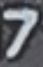

In [161]:
# random choice input image
filenames = os.listdir('../data')
filename = random.choice(filenames)

# show image
image = Image.open(os.path.join('../data',filename))
image

In [162]:
IMAGE_SHAPE = (32,32)
transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE), # Resize the input image
    transforms.ToTensor(), # Convert to torch tensor (scales data into [0,1])
    transforms.Lambda(lambda t: (t * 2) - 1), # Scale data between [-1, 1] 
])


reverse_transform = transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2), # Scale data between [0,1]
    transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
    transforms.Lambda(lambda t: t * 255.), # Scale data between [0.,255.]
    transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)), # Convert into an uint8 numpy array
    transforms.ToPILImage(), # Convert to PIL image
])

In [163]:
# test transform function
torch_image = transform(image)
torch_image.shape

torch.Size([3, 32, 32])

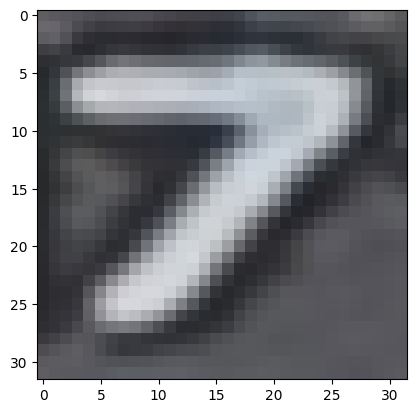

In [164]:
# test reverse transform function
plt.imshow(reverse_transform(torch_image))

In [181]:
t = torch.tensor([0,1,2,3,4]) # batch of 5 t value
batch_images  = torch.stack([torch_image] * t.size()[0]) # batch of 5 image
noisy_images,_ = forward_diffusion(batch_images,t)

noisy_images.size()

torch.Size([5, 3, 32, 32])

torch.Size([3, 32, 32])


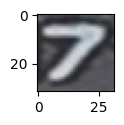

torch.Size([3, 32, 32])


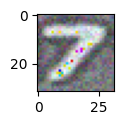

torch.Size([3, 32, 32])


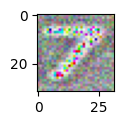

torch.Size([3, 32, 32])


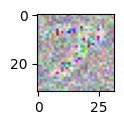

torch.Size([3, 32, 32])


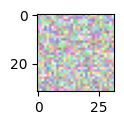

In [190]:
for img in noisy_images:
    print(img.size())
    plt.figure(figsize=(1,1))
    plt.imshow(reverse_transform(img))
    plt.show()

In [216]:
def plot_forward_diffusion(noisy_images):
    plt.figure(figsize=(15,15))
    f, ax = plt.subplots(1, noisy_images.size()[0], figsize = (100,100))
    
    for idx, image in enumerate(noisy_images):
        ax[idx].imshow(reverse_transform(image))
        ax[idx].set_title(f"Iteration: {t[idx].item()}", fontsize = 100)
    plt.show() 

<Figure size 1500x1500 with 0 Axes>

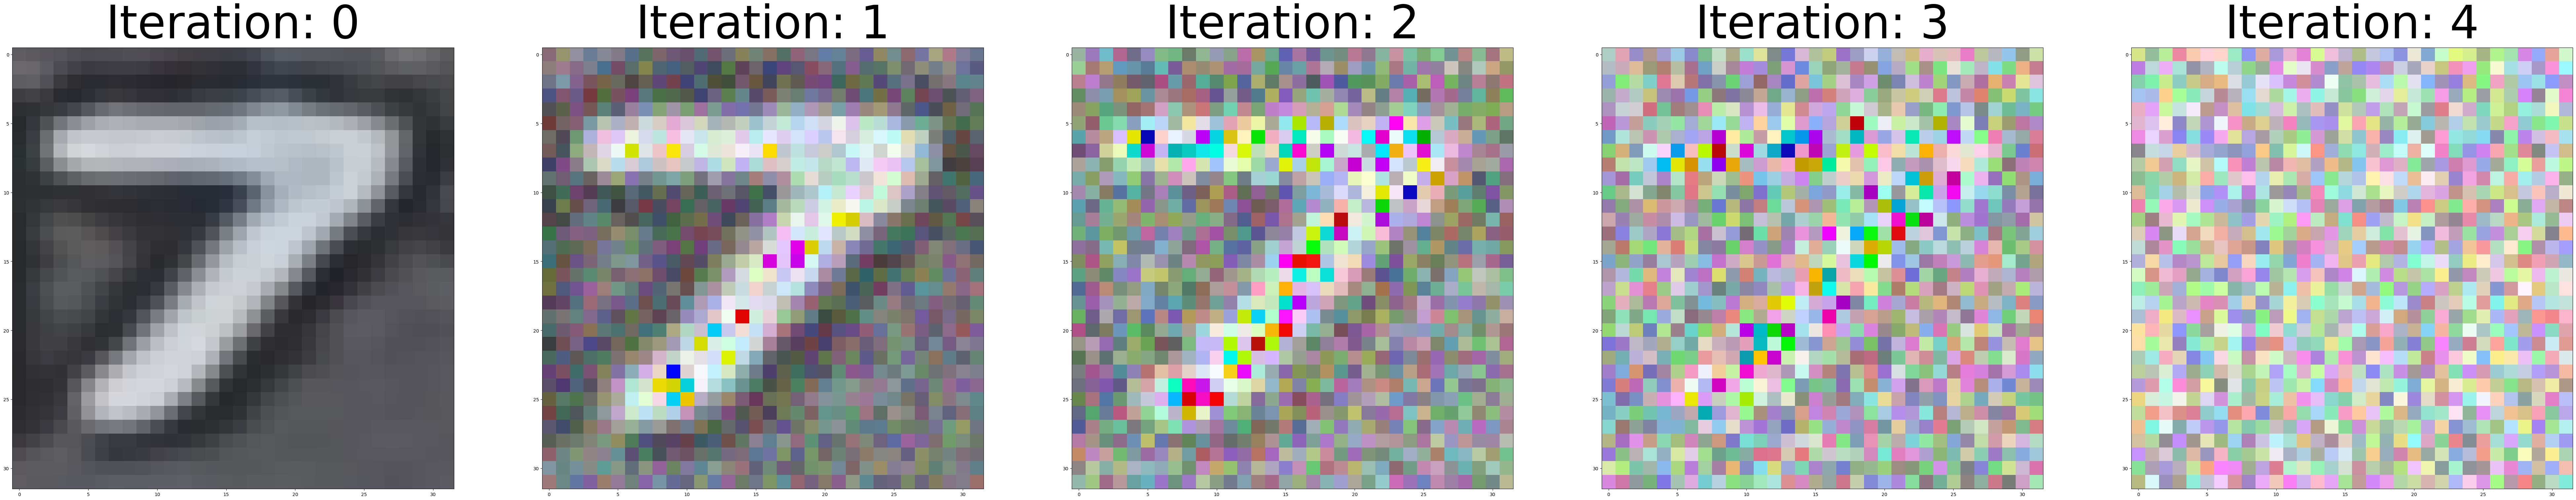

In [217]:
plot_forward_diffusion(noisy_images)

In [ ]:
class DiffusionModel:
    def __init__(self, start_schedule=0.0001, end_schedule=0.02, timesteps = 300):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps
        
        """
        if 
            betas = [0.1, 0.2, 0.3, ...]
        then
            alphas = [0.9, 0.8, 0.7, ...]
            alphas_cumprod = [0.9, 0.9 * 0.8, 0.9 * 0.8, * 0.7, ...]
            
        
        """ 
        self.betas = torch.linspace(start_schedule, end_schedule, timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        
    def forward(self, x_0, t, device):
        """
        x_0: (B, C, H, W)
        t: (B,)
        """
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alphas_cumprod.sqrt(), t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x_0.shape)
            
        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)
        
        return mean + variance, noise.to(device)

In [196]:
# define Diffusion model class
class DiffusionModel:
    def __init__(self,start_schedule=0.0001,end_schedule=0.02, timesteps=300):
        self.start_schedule = start_schedule
        self.end_schedule= end_schedule
        self.timesteps = timesteps
        """
        if 
            betas = [0.1, 0.2, 0.3, ...]
        then
            alphas = [0.9, 0.8, 0.7, ...]
            alphas_cumprod = [0.9, 0.9 * 0.8, 0.9 * 0.8, * 0.7, ...]
            
        
        """
        self.betas = torch.linspace(start_schedule,end_schedule,timesteps)
        self.alphas = 1 - self.betas
        self.alpha_hat = torch.cumprod(alphas,axis=0)
        self.alpha_hat_t = alpha_hat.gather(-1,t).reshape(-1,1,1,1)
        
    def forward(self,x_0,t,device):
        """
        x_0: (B, C, H, W)
        t: (B,)
        """
        noise = torch.randn_like(x_0)
        mean = self.alpha_hat_t.sqrt().to(device) * x_0.to(device)
        variance = torch.sqrt(1-self.alpha_hat_t).to(device) * noise.to(device)
        return mean + variance, noise.to(device)

In [197]:
diffusion_model = DiffusionModel()

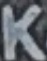

In [225]:
# get random image
filename = random.choice(filenames)
pil_image = Image.open(os.path.join('../data',filename))
torch_image = transform(pil_image)
pil_image

<Figure size 1500x1500 with 0 Axes>

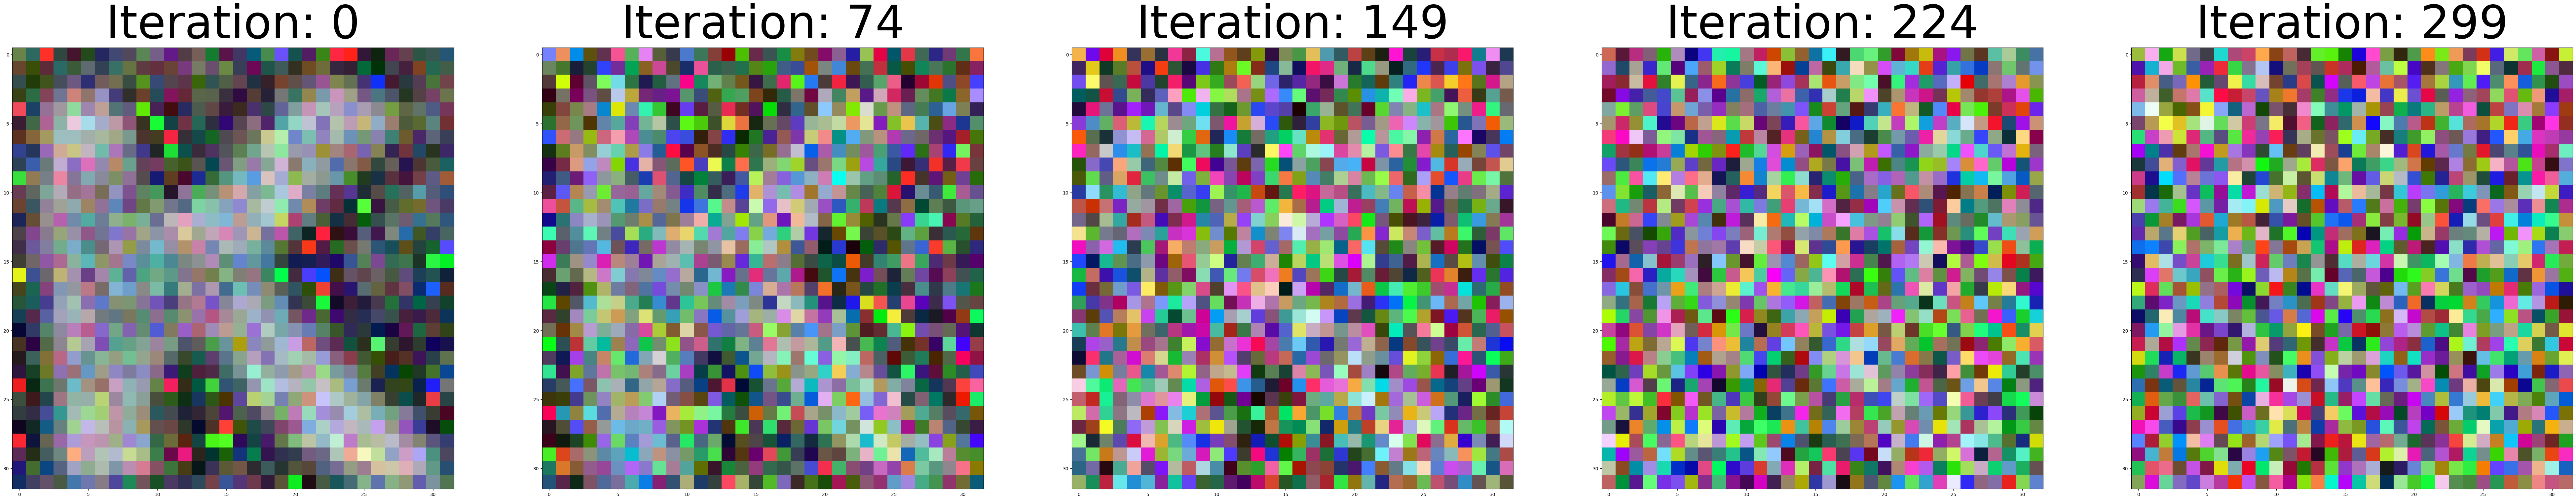

In [226]:
NO_DISPLAY_IMAGES = 5
torch_image_batch = torch.stack([torch_image] * NO_DISPLAY_IMAGES)
t = torch.linspace(0, diffusion_model.timesteps - 1, NO_DISPLAY_IMAGES).long()
noisy_image_batch, _ = diffusion_model.forward(torch_image_batch, t, device)

plot_forward_diffusion(noisy_image_batch)

https://www.youtube.com/watch?v=S_il77Ttrmg

https://github.com/dtransposed/code_videos/blob/main/Diffusion%20Model.ipynb

https://lilianweng.github.io/posts/2021-07-11-diffusion-models/